<a href="https://colab.research.google.com/github/KurtisZ18/Predicting-Commodities/blob/main/Commodity_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Commodity Price Prediction Colab
For-fun colab to predict commodity prices using past data with ML applications.

In [ ]:
# Computation imports
import pandas as pd
from pandas_datareader import data as pdr

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from datetime import datetime

# yahoo finance
import yfinance as yf

## Agriculture Commodities

### Soybean Prices

Using LSTM to predict soy prices from Yahoo Finance data and Weather data from the soybelt state (Illinois).

In [ ]:
# Loading soy data
today = datetime.today().strftime('%Y-%m-%d')
soy_df = yf.download("ZS=F", start="2015-01-01", end=today)

# Keep only the close price and change df structure
soy_df = pd.DataFrame(soy_df['Close'])
soy_df.columns = ['Soy_Price']
soy_df = soy_df.reset_index()
soy_df['Date'] = pd.to_datetime(soy_df['Date'])

soy_df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Date,Soy_Price
0,2015-01-02,1002.50
1,2015-01-05,1039.75
2,2015-01-06,1051.00
3,2015-01-07,1052.75
4,2015-01-08,1045.00


In [ ]:
# Coordinates for Illinois
latitude, longitude = 40.0, -89.0

# Retrieving weather from Open-Meteo API
weather_url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date=2015-01-01&end_date={today}&daily=temperature_2m_max,precipitation_sum&timezone=America%2FChicago"
weather_json = pd.read_json(weather_url)

weather_df = pd.DataFrame(weather_json['daily']['time'], columns=['Date'])
weather_df['Temp_Max'] = weather_json['daily']['temperature_2m_max']
weather_df['Precip'] = weather_json['daily']['precipitation_sum']
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
weather_df.set_index('Date', inplace=True)

# Merge weather data with soy data
data = soy_df.join(weather_df, on='Date', how='inner')
data.head()


,Date,Soy_Price,Temp_Max,Precip
0,2015-01-02,1002.50,3.4,0.0
1,2015-01-05,1039.75,-8.5,3.0
2,2015-01-06,1051.00,-7.1,0.3
3,2015-01-07,1052.75,-10.5,0.0
4,2015-01-08,1045.00,-3.3,0.0


In [ ]:
# Get features
features = ['Soy_Price', 'Temp_Max', 'Precip']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# Sequences of 30 Days
def create_sequences_multivariate(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0]) # for soy price only
    return np.array(X), np.array(y)

SEQ_LENGTH = 30
X, y = create_sequences_multivariate(scaled_data, SEQ_LENGTH)

# Split data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential()
model.add(LSTM(64, input_shape=(SEQ_LENGTH, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

y_pred_scaled = model.predict(X_test)

# Recreate full-scale prices
soy_price_scaler = MinMaxScaler()
soy_price_scaler.min_, soy_price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]
y_pred = soy_price_scaler.inverse_transform(y_pred_scaled)
y_test_actual = soy_price_scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0461 - val_loss: 0.0020
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.5361e-04 - val_loss: 0.0022
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.7774e-04 - val_loss: 0.0020
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.3521e-04 - val_loss: 0.0019
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.7239e-04 - val_loss: 0.0018
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.4375e-04 - val_loss: 0.0018
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.1754e-04 - val_loss: 0.0018
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.4015e-04 - val_loss: 0.0018
Epoch 9/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.4996e-04 - val_loss: 0.0017
Epoch 10/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.1103e-04 - val_loss: 0.0017
Epoch 11/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.7915e-04 - val_loss: 0.0016
Epoch 12/20
58/58 ━━━━━━━━━━━━━━━━

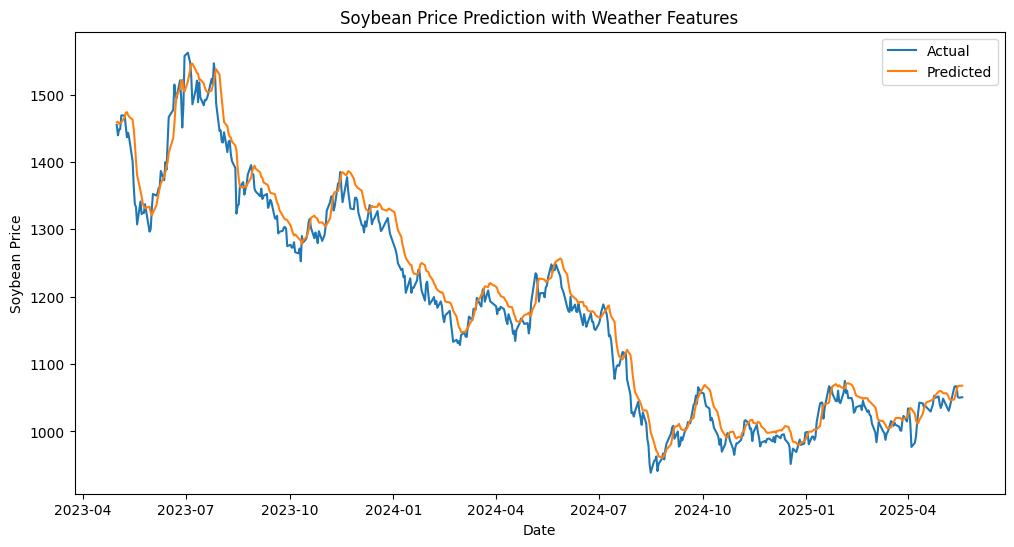

In [ ]:
# Plotting prices
test_dates = data['Date'][split + SEQ_LENGTH:].reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, label='Actual')
plt.plot(test_dates, y_pred, label='Predicted')
plt.title('Soybean Price Prediction with Weather Features')
plt.xlabel('Date')
plt.ylabel('Soybean Price')
plt.legend()
plt.show()

 Day Predicted Price
   1         1080.37
   2         1084.95
   3         1090.02
   4         1095.89
   5         1102.70
   6         1110.72
   7         1119.46
   8         1128.90
   9         1138.94
  10         1149.26


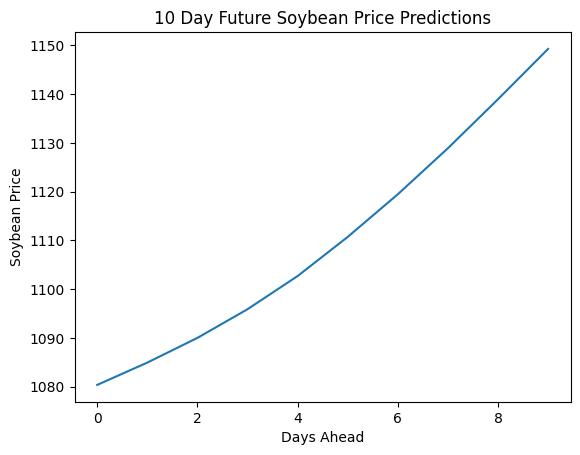

In [ ]:
def predict_future_prices(model, scaled_data, scaler, seq_length=30, future_days=30):
  # Prepare last known sequence
  last_sequence = scaled_data[-seq_length:]
  current_sequence = np.expand_dims(last_sequence, axis=0)

  future_predictions_scaled = []

  for _ in range(future_days):
      next_price_scaled = model.predict(current_sequence, verbose=0)[0][0]
      future_predictions_scaled.append(next_price_scaled)

      next_day_features = current_sequence[0, -1].copy()
      next_day_features[0] = next_price_scaled  # Replace only Soy_Price

      current_sequence = np.append(current_sequence[:, 1:, :], [[next_day_features]], axis=1)

  # Use the soy_price_scaler (fitted on actual Soy_Price data)
  future_predictions = soy_price_scaler.inverse_transform(
      np.array(future_predictions_scaled).reshape(-1, 1)
  )

  return future_predictions

soy_price_scaler = MinMaxScaler()
soy_price_scaler.fit(data[['Soy_Price']])

scaled_data = np.nan_to_num(scaled_data)

future_predictions = predict_future_prices(
    model=model,
    scaled_data=scaled_data,
    scaler=soy_price_scaler,
    seq_length=10,
    future_days=10
)

# Printing predicted prices
days = range(1, len(future_predictions) + 1)
predictions_table = pd.DataFrame({
    'Day': days,
    'Predicted Price': future_predictions.flatten()
})
predictions_table['Predicted Price'] = predictions_table['Predicted Price'].apply(lambda x: f"{x:.2f}")
print(predictions_table.to_string(index=False))

# Plotting predicted prices
plt.plot(future_predictions)
plt.title("10 Day Future Soybean Price Predictions")
plt.xlabel("Days Ahead")
plt.ylabel("Soybean Price")
plt.show()

### Wheat Prices

In [ ]:
# Load wheat data
wheat_df = yf.download("ZW=F", start="2015-01-01", end=today)

# Keep only the close price and change df structure
wheat_df = pd.DataFrame(wheat_df['Close'])
wheat_df.columns = ['Wheat_Price']
wheat_df = wheat_df.reset_index()
wheat_df['Date'] = pd.to_datetime(wheat_df['Date'])

wheat_df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Wheat_Price
0,2015-01-02,581.25
1,2015-01-05,589.00
2,2015-01-06,591.75
3,2015-01-07,579.50
4,2015-01-08,567.00


In [ ]:
# Economic factors to account for
interest = pdr.DataReader("FEDFUNDS", "fred", '2015-01-01', today)

# Merge to daily using forward-fill
econ = pd.DataFrame(interest)
econ.columns = ['Interest_Rate']
econ = econ.resample('D').ffill()

# Merge all data
data = pd.merge(wheat_df, econ, left_on='Date', right_index=True, how='inner')
data = data.dropna()

In [ ]:
features = ['Wheat_Price', 'Interest_Rate']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# Create sequences
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 30
X, y = create_sequences(scaled_data, SEQ_LENGTH)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential()
model.add(LSTM(64, input_shape=(SEQ_LENGTH, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

y_pred_scaled = model.predict(X_test)

# Inverse transform only wheat price
wheat_scaler = MinMaxScaler()
wheat_scaler.min_, wheat_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

y_pred = wheat_scaler.inverse_transform(y_pred_scaled)
y_test_actual = wheat_scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0129 - val_loss: 0.0036
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.2225e-04 - val_loss: 0.0020
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.6629e-04 - val_loss: 0.0013
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.7253e-04 - val_loss: 0.0032
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.3723e-04 - val_loss: 0.0015
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.2256e-04 - val_loss: 9.0065e-04
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.6091e-04 - val_loss: 0.0011
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.0128e-04 - val_loss: 0.0010
Epoch 9/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.1167e-04 - val_loss: 9.8306e-04
Epoch 10/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.0617e-04 - val_loss: 0.0010
Epoch 11/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.1495e-04 - val_loss: 8.1751e-04
Epoch 12/20
58/58 ━━━━

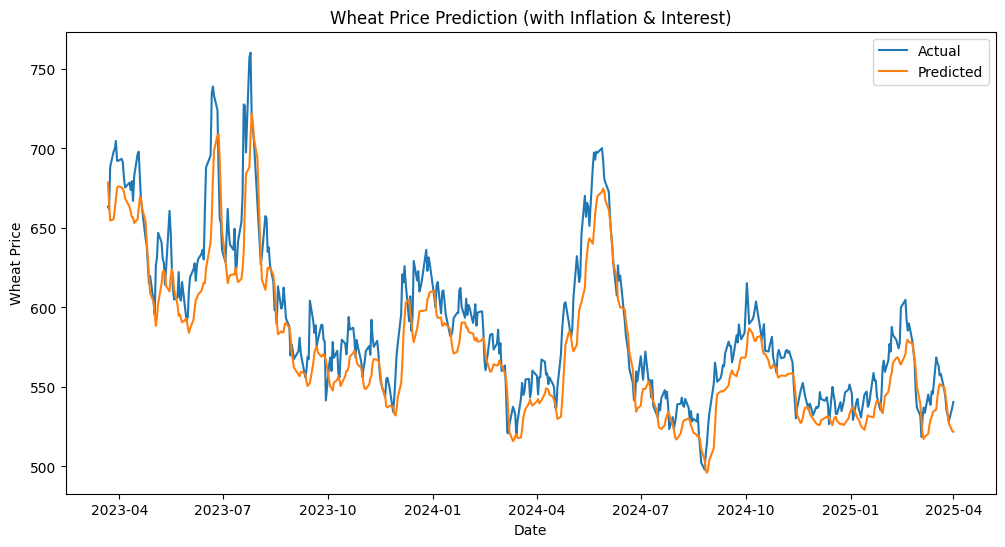

In [ ]:
test_dates = data['Date'][split + SEQ_LENGTH:].reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, label='Actual')
plt.plot(test_dates, y_pred, label='Predicted')
plt.title('Wheat Price Prediction (with Inflation & Interest)')
plt.xlabel('Date')
plt.ylabel('Wheat Price')
plt.legend()
plt.show()

Day 1: 523.66
Day 2: 518.58
Day 3: 514.97
Day 4: 512.67
Day 5: 510.98
Day 6: 509.47
Day 7: 507.89
Day 8: 506.12
Day 9: 504.11
Day 10: 501.85


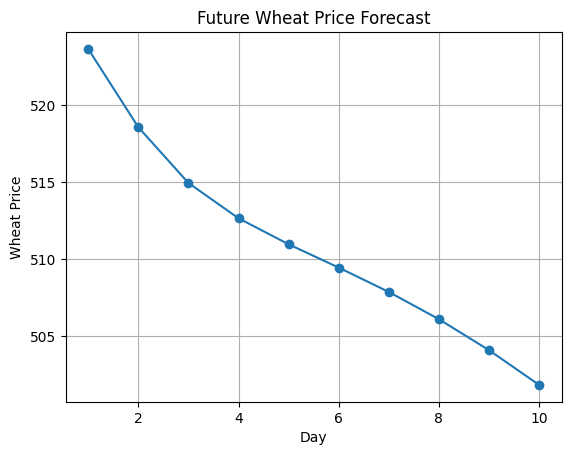

In [ ]:
def predict_future_prices(model, scaler, last_sequence, future_interest_rates, n_days):
  future_predictions = []

  current_sequence = last_sequence.copy()

  for i in range(n_days):
      input_seq = current_sequence.reshape(1, SEQ_LENGTH, 2)
      next_scaled_price = model.predict(input_seq, verbose=0)[0][0]

      future_predictions.append(next_scaled_price)

      next_interest = future_interest_rates[i]

      interest_scaled = (next_interest - scaler.data_min_[1]) / (scaler.data_max_[1] - scaler.data_min_[1])

      next_day = [next_scaled_price, interest_scaled]
      current_sequence = np.vstack([current_sequence[1:], next_day])

  padded = np.hstack([np.array(future_predictions).reshape(-1, 1), np.zeros((n_days, 1))])
  wheat_pred = scaler.inverse_transform(padded)[:, 0]

  return wheat_pred

last_sequence = scaled_data[-SEQ_LENGTH:]
future_interest_rates = [5.25]*10

future_prices = predict_future_prices(model, scaler, last_sequence, future_interest_rates, n_days=10)

for i, price in enumerate(future_prices, 1):
    print(f"Day {i}: {price:.2f}")

plt.plot(range(1, 11), future_prices, marker='o')
plt.title('Future Wheat Price Forecast')
plt.xlabel('Day')
plt.ylabel('Wheat Price')
plt.grid(True)
plt.show()


## Energy Commodities

### Crude Oil Prices

## Metals Commodities

### Gold Prices